In [84]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import date as fuck

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Precipitation

Date
2013-12-31     0.000000
2014-01-15     1.503125
2014-01-31     1.636667
2014-02-15     0.000000
2014-02-28     0.475000
                ...    
2022-04-15     1.692727
2022-04-30     4.052381
2022-05-15     1.450893
2022-05-31     3.106667
2022-06-15    28.203333
Freq: SM-15, Name: Percipitation, Length: 204, dtype: float64


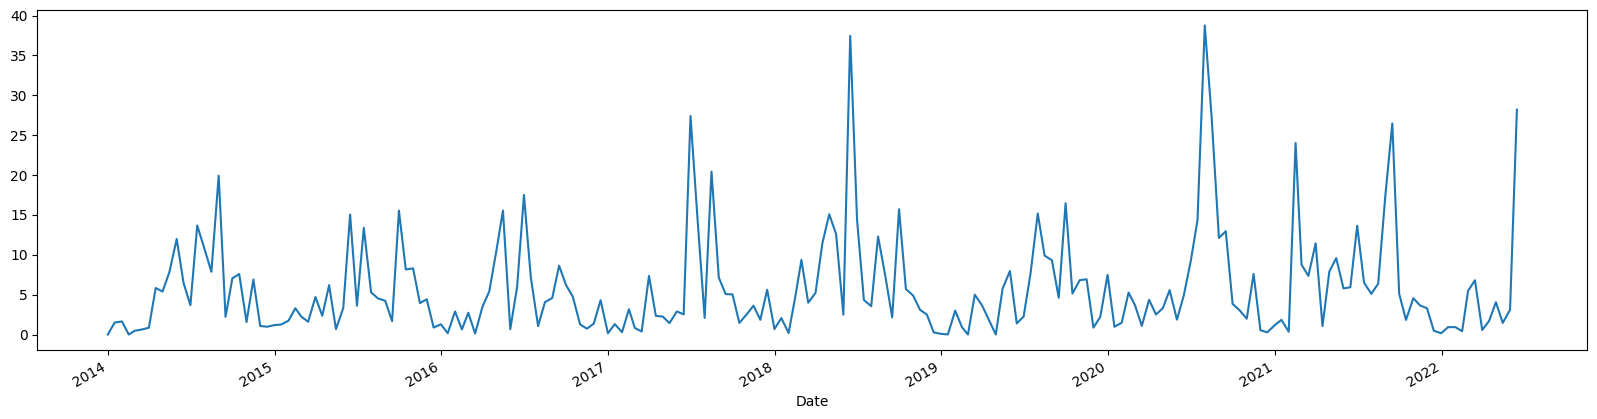

In [27]:
per = pd.read_csv("C:/Users/YYY/Desktop/project/DailyPrecipitation.csv", usecols=['Date', 'Percipitation'])
per['Date'] = pd.to_datetime(per['Date'])
per = per.set_index('Date')
per = per.interpolate()
per = per.resample('SM').mean()
per = per.squeeze()
per = per[:-1]
per.plot(figsize=(20,5))
print(per)


<AxesSubplot:xlabel='Date'>

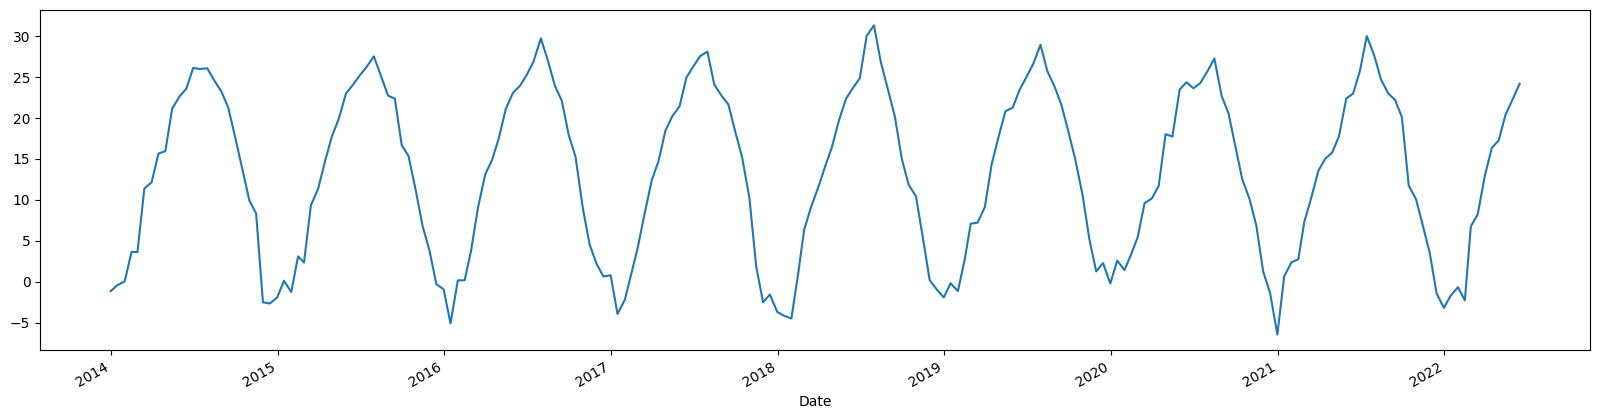

In [30]:
temp = pd.read_csv("C:/Users/YYY/Desktop/project/DailyTemp.csv", usecols=['Date', 'temp'])
temp['Date'] = pd.to_datetime(temp['Date'])
temp = temp.set_index('Date')
temp = temp.interpolate()
temp = temp.resample('SM').mean()
temp = temp.squeeze()
temp = temp[:-1]
temp.plot(figsize=(20,5))

<AxesSubplot:xlabel='Date'>

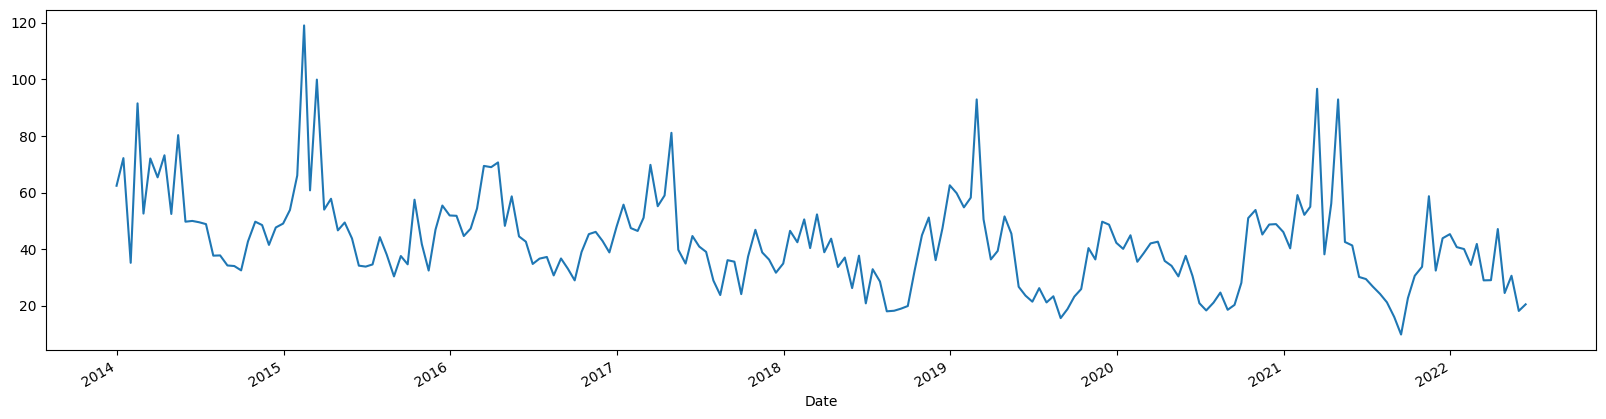

In [31]:
df = pd.DataFrame()
for i in range(14, 20):
    for j in range(1, 13):
        file_name = f"C:/Users/YYY/Desktop/project/Data/20{i}_{j}.xls"
        d = pd.read_excel(file_name, usecols=['날짜', 'PM10'], skiprows=(1,))
        d.rename(columns={'날짜':'Date'}, inplace=True)
        d['Date'] = pd.to_datetime(d['Date'])
        d = d.set_index('Date')
        df = d if i == 14 and j == 1 else pd.concat([df, d])

for i in range(20, 23):
    for j in range(1, 13):
        try:
            file_name = f"C:/Users/YYY/Desktop/project/PM10Data(20-22)/data_past_day({i}-{j}).xls"
            d = pd.read_excel(file_name, usecols=['날짜', 'PM10'], skiprows=(1,))
            d.rename(columns={'날짜':'Date'}, inplace=True)
            d['Date'] = pd.to_datetime(d['Date'])
            d = d.set_index('Date')
            df = pd.concat([df, d])
        except:
            break
df = df.interpolate()
df = df.resample('SM').mean()
df = df.squeeze()
df = df[:-1]
df.plot(figsize=(20,5))

In [32]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

Percipitation

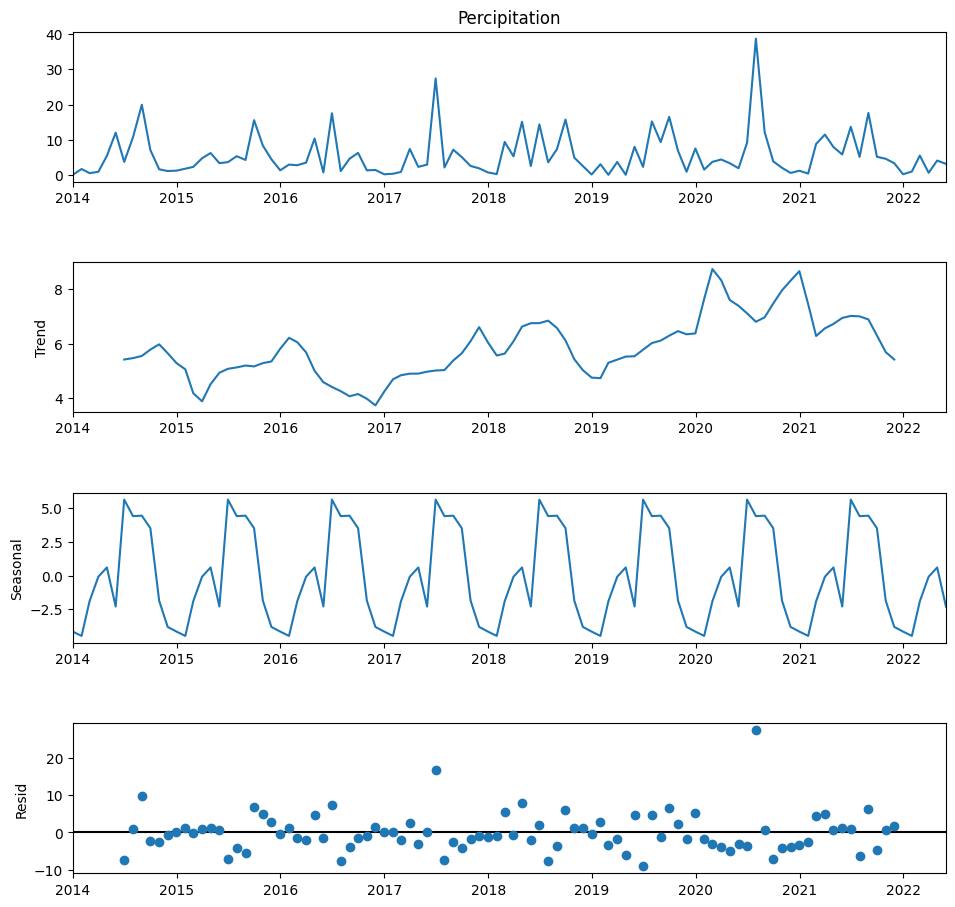

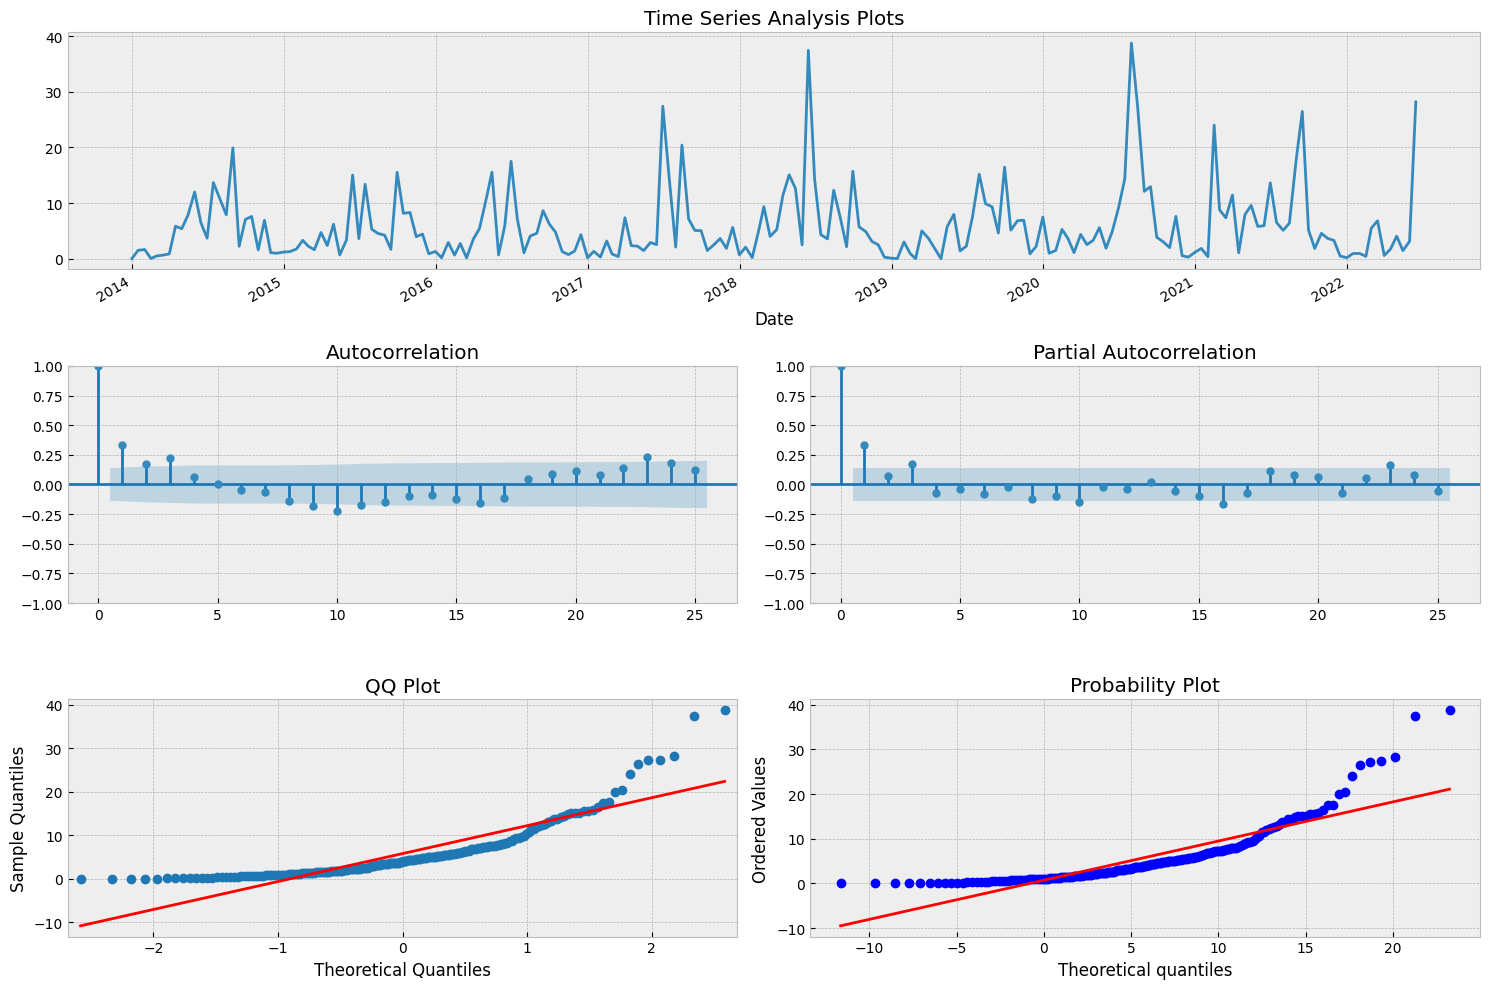

In [38]:
decomposition= sm.tsa.seasonal_decompose(per.asfreq('M'), model='additive')
ax = decomposition.plot()
ax.set_size_inches(10,10)
plt.show()
tsplot(per, lags=25)


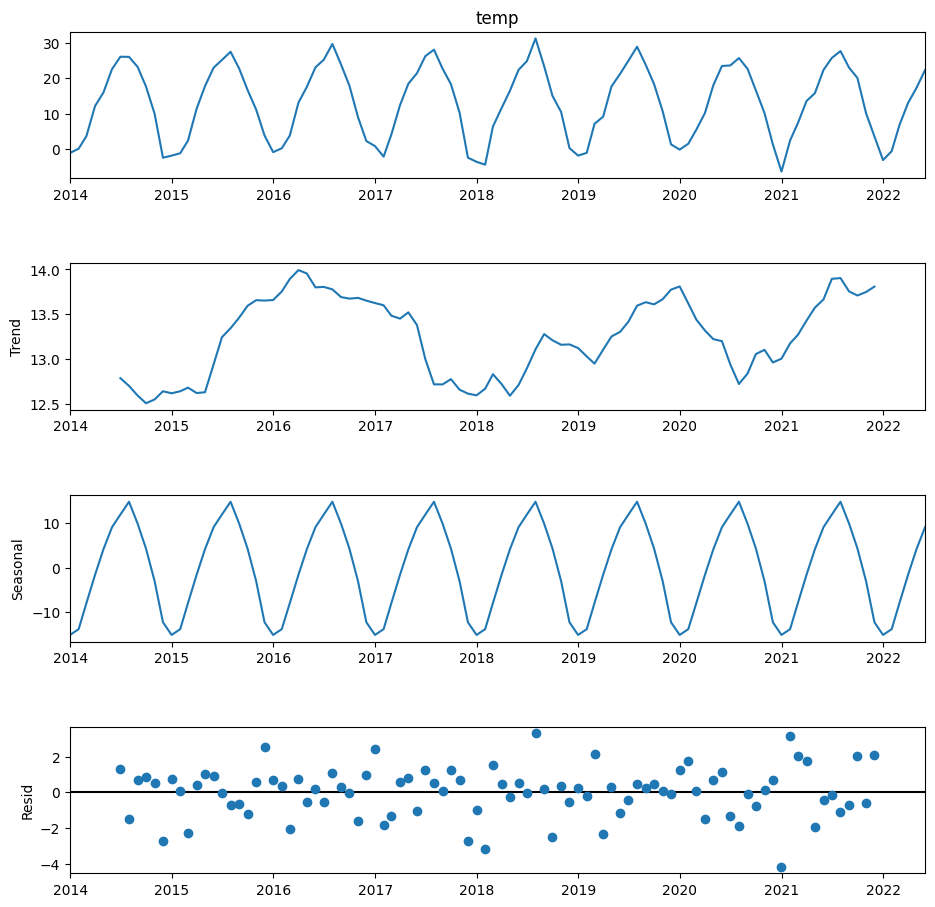

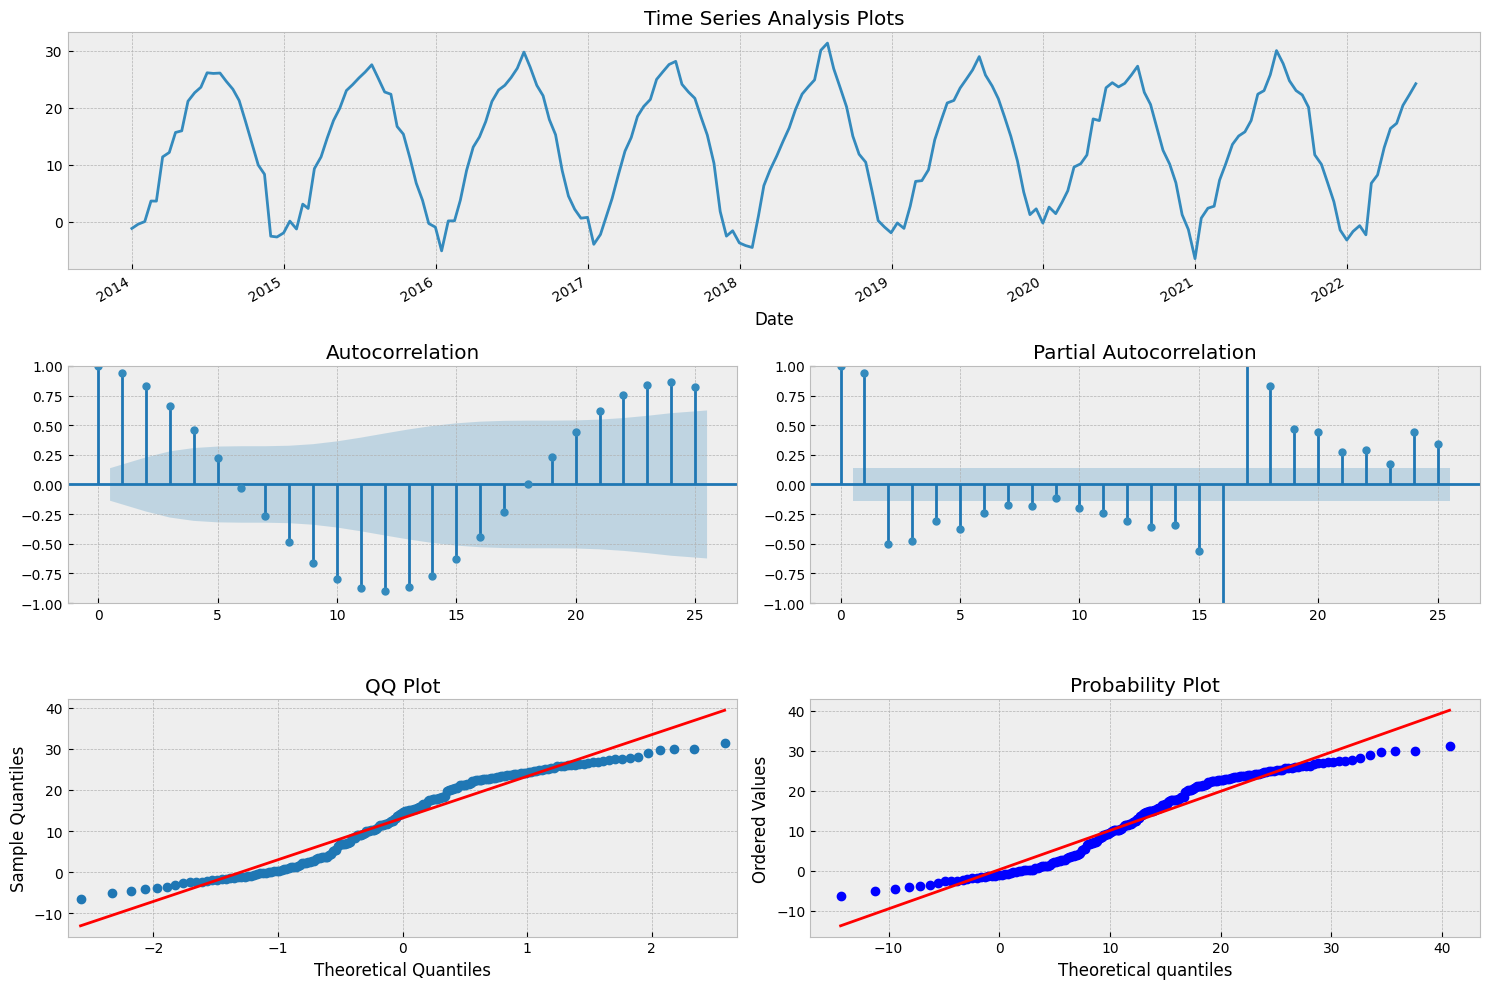

In [39]:
decomposition= sm.tsa.seasonal_decompose(temp.asfreq('M'), model='additive')
ax = decomposition.plot()
ax.set_size_inches(10,10)
plt.show()
tsplot(temp, lags=25)

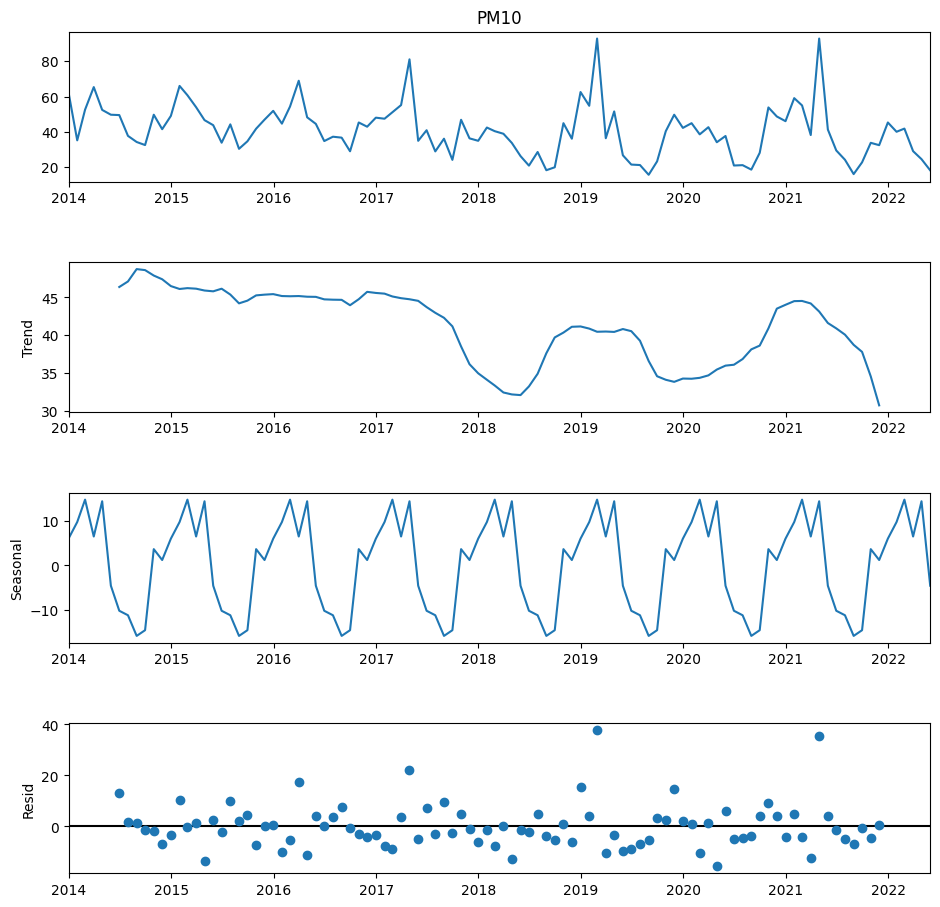

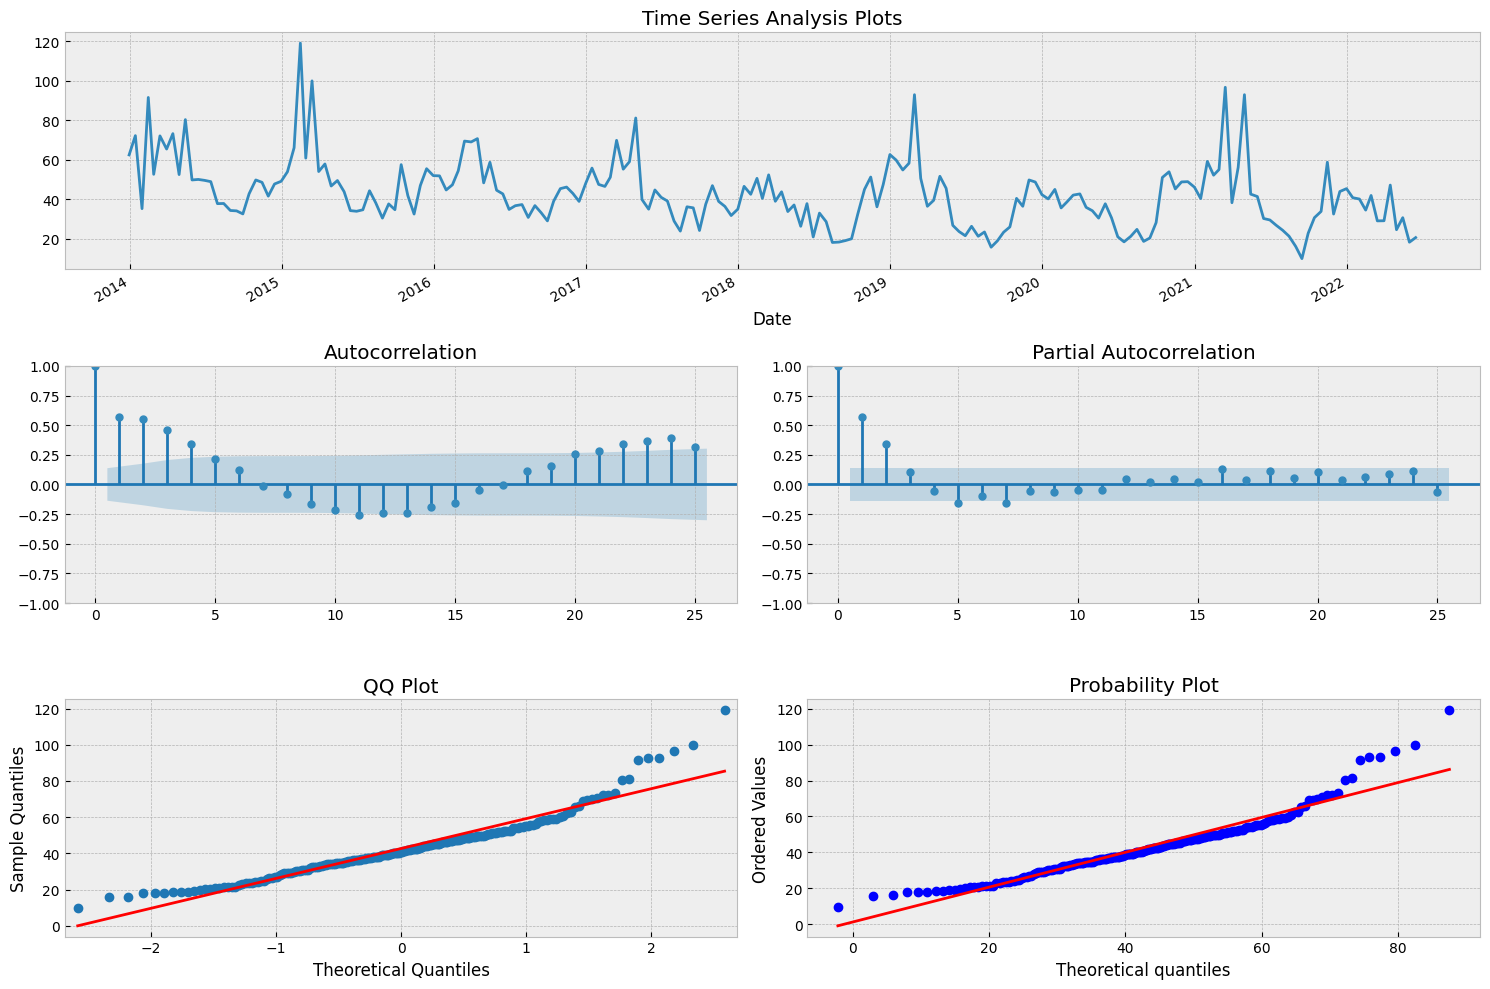

In [40]:
decomposition= sm.tsa.seasonal_decompose(df.asfreq('M'), model='additive')
ax = decomposition.plot()
ax.set_size_inches(10,10)
plt.show()
tsplot(df, lags=25)

In [61]:
def differencing(data, shift=1, order=1, l=24, show=False):
    diff = None
    if order == 1:
        diff = data.diff(periods=shift).iloc[shift:]
    elif order == 2:
        diff = data.diff(periods=shift).diff(periods=shift).iloc[2:]
    adf_test = adfuller(diff)
    print('ADF Statistic: %f' % adf_test[0])
    print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
    print('p-value: %20.20f' % adf_test[1])
    if show:
        plt.figure(figsize=(10,5))
        plt.plot(diff, label=f'After {order}nd differencing with shift {shift}')
        plt.legend(loc='best')
        plt.title(f'After {order}nd differencing with shift {shift}')
        plt.show()
    return diff

In [62]:
def trend(data, show=False):
    x = np.arange(len(data))
    f = 1/24
    X = np.column_stack((np.ones(len(x)), x,
                        np.sin(2* np.pi * f*x), np.cos(2* np.pi * f*x)))
    curve_reg = sm.OLS(data, X).fit()
    y_hat = curve_reg.predict(X)
    data_trend = data  - y_hat

    if show:
        plt.figure(figsize=(20, 5))
        plt.plot(x,data,label='AAPL Close') # original data
        plt.plot(x,y_hat,label='Curved Regression Line') # regression line
        plt.xlabel('Time')
        plt.ylabel('Closing Price')
        plt.legend();
        plt.figure(figsize=(20, 5))
        plt.plot(x, data_trend, label='Curved Regression Line') # regression line
        plt.xlabel('Time')
        plt.ylabel('Closing Price')
        plt.legend();
    return data_trend

Transformed percipitation

ADF Statistic: -16.302817
Critical Values @ 0.05: -2.88
p-value: 0.00000000000000000000


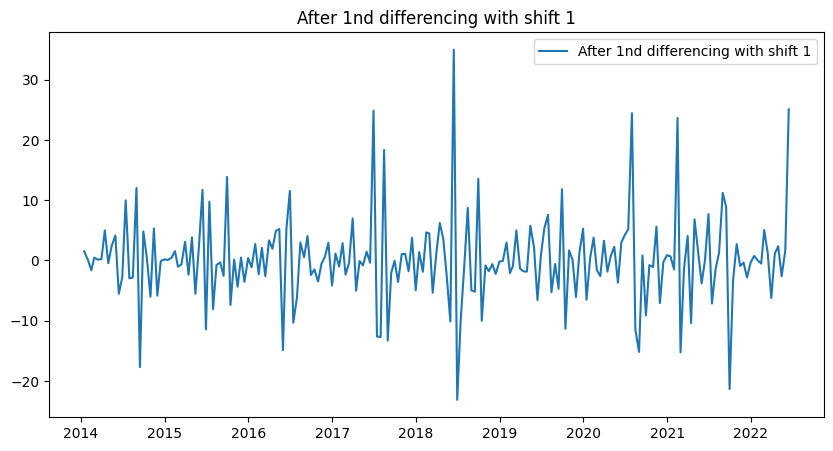

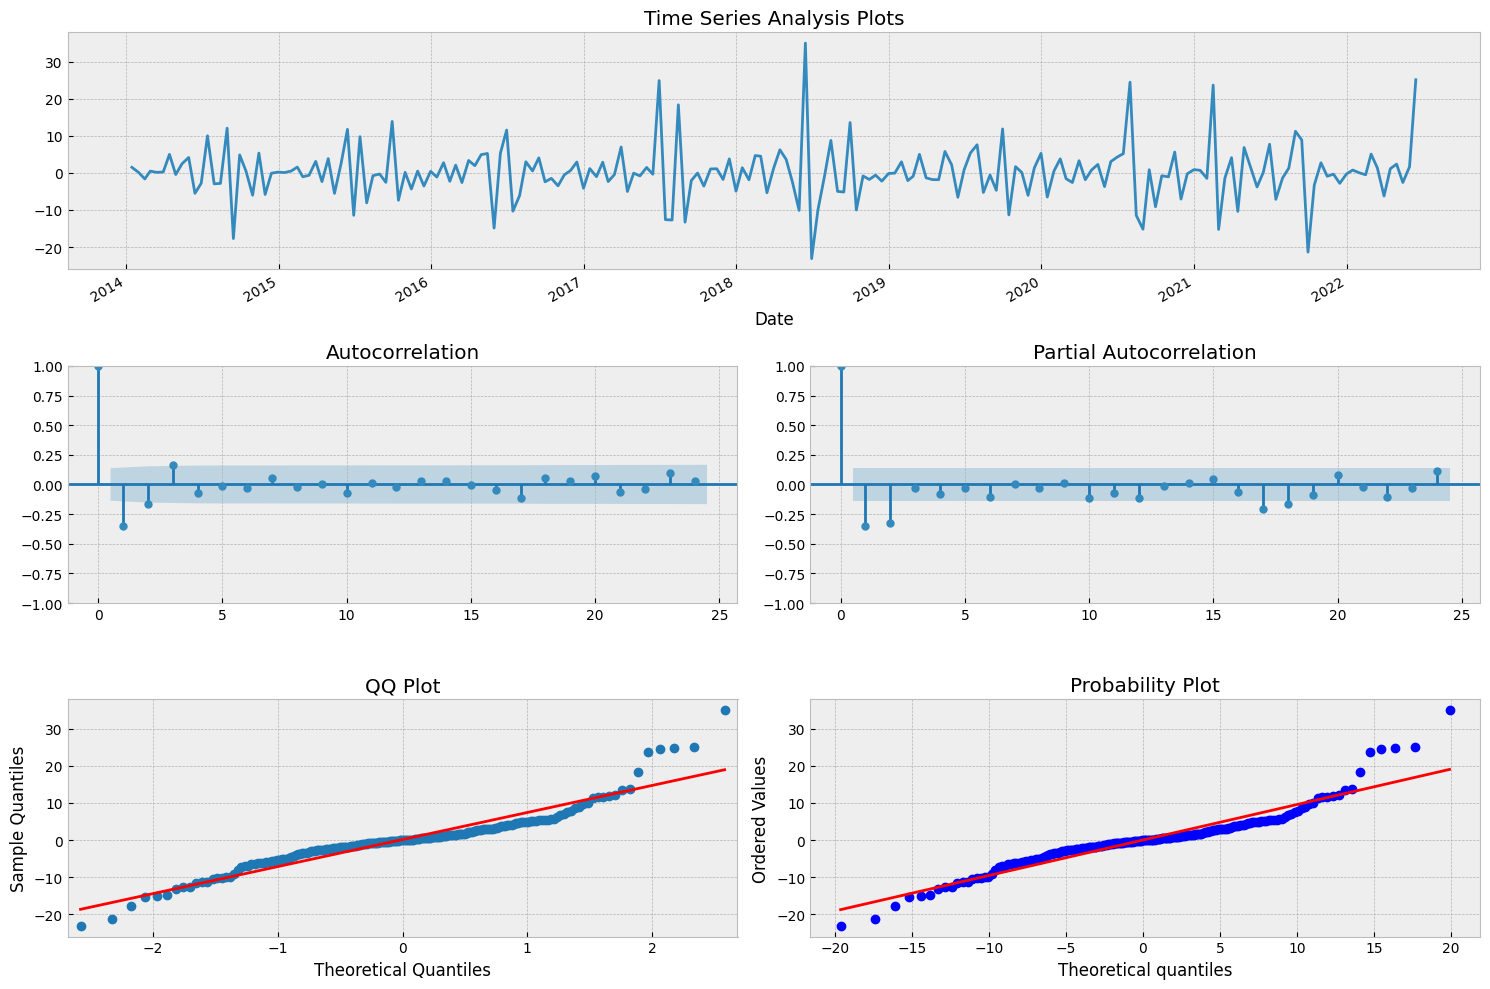

In [67]:
diff_per = differencing(per, order=1, l=30, show=True)
per_trend = trend(per, show=True)
tsplot(per_trend)

Transformed temperature

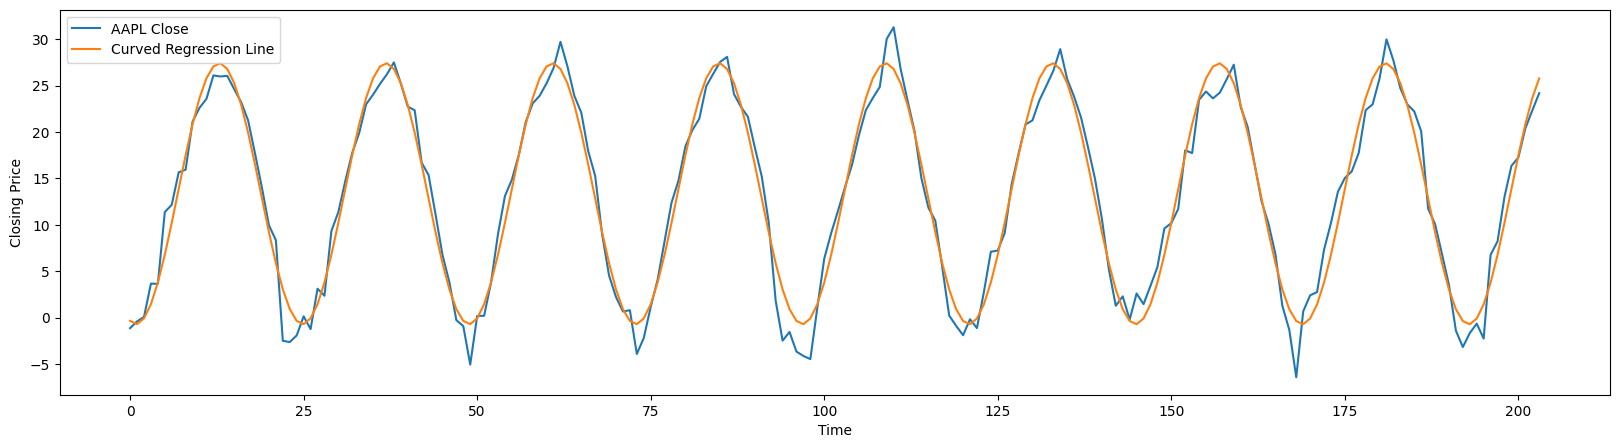

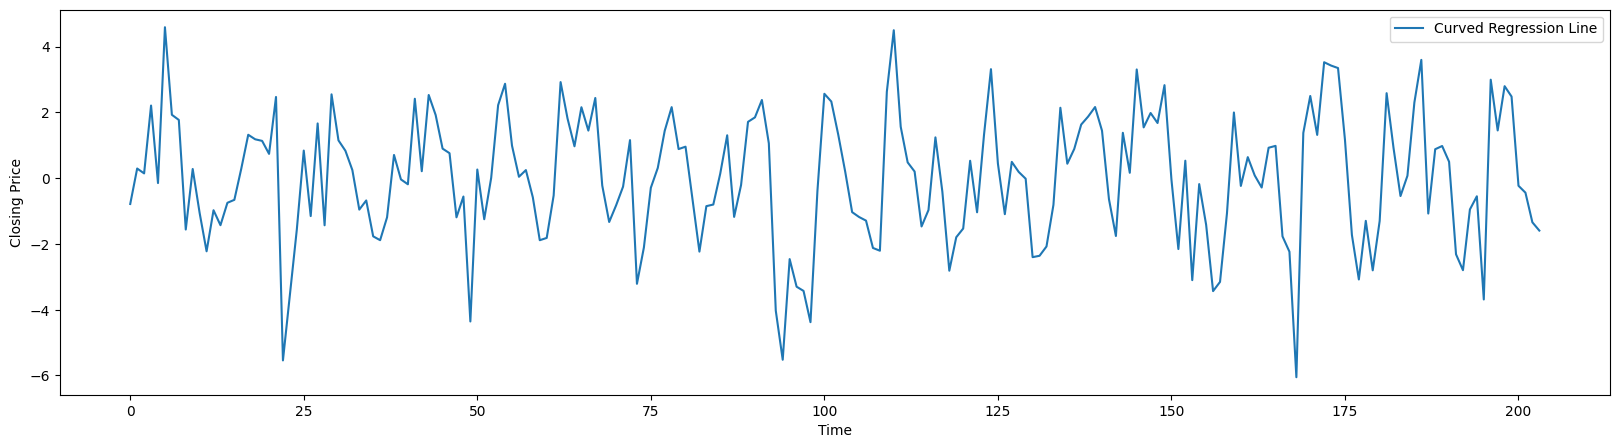

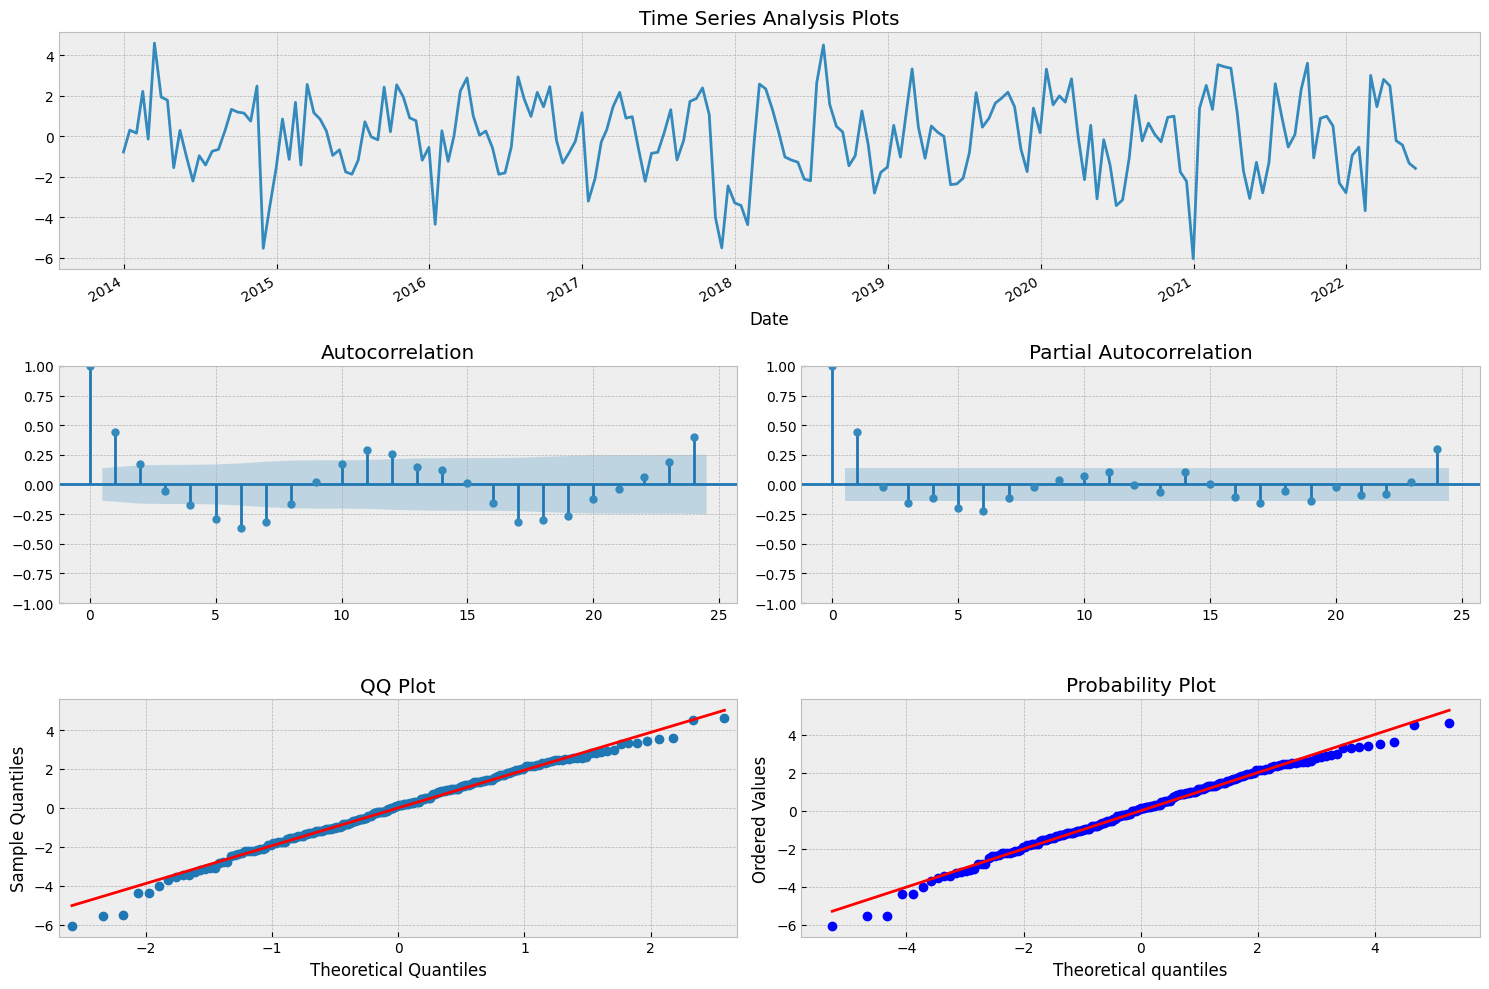

In [59]:
temp_trend = trend(temp, True)
tsplot(temp_trend)

Transformed pm10

ADF Statistic: -14.658395
Critical Values @ 0.05: -2.88
p-value: 0.00000000000000000000


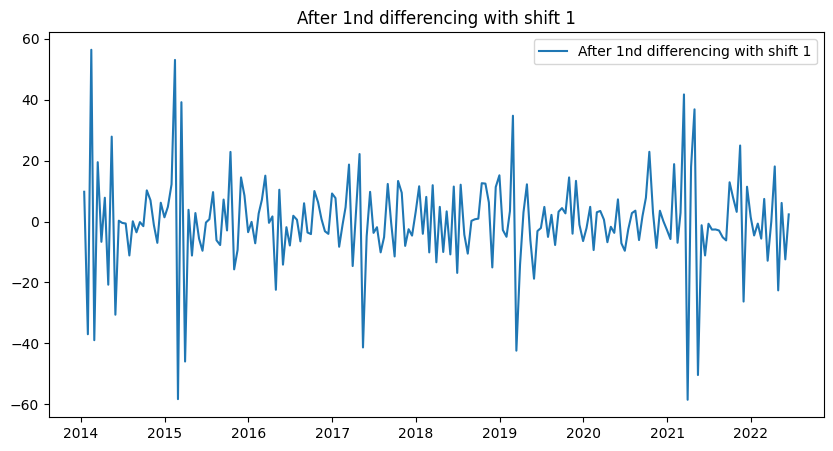

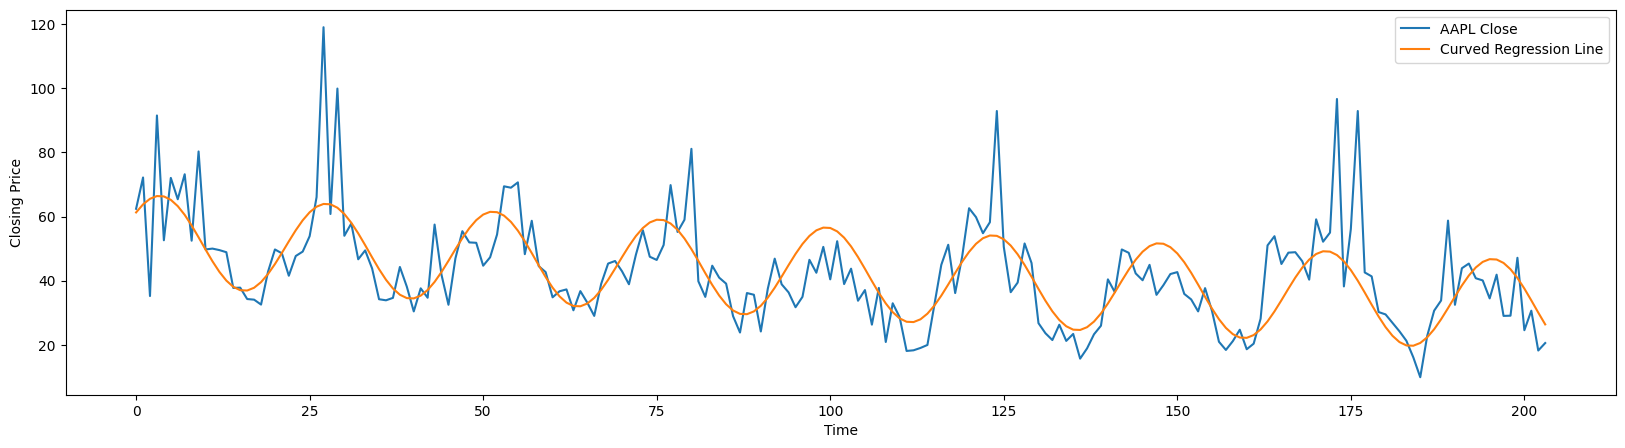

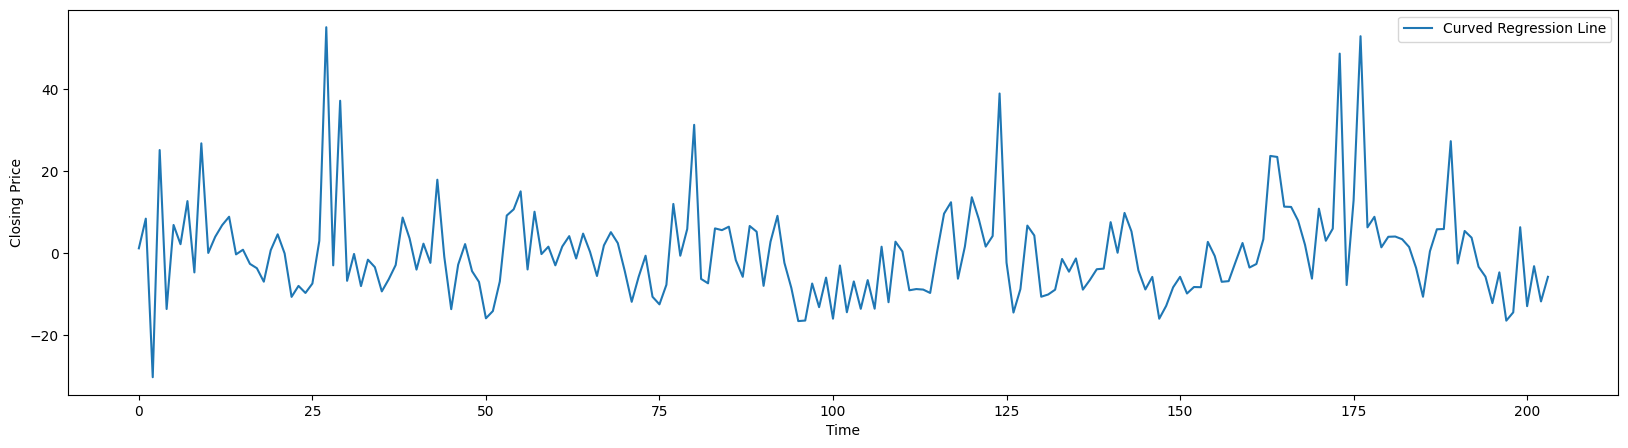

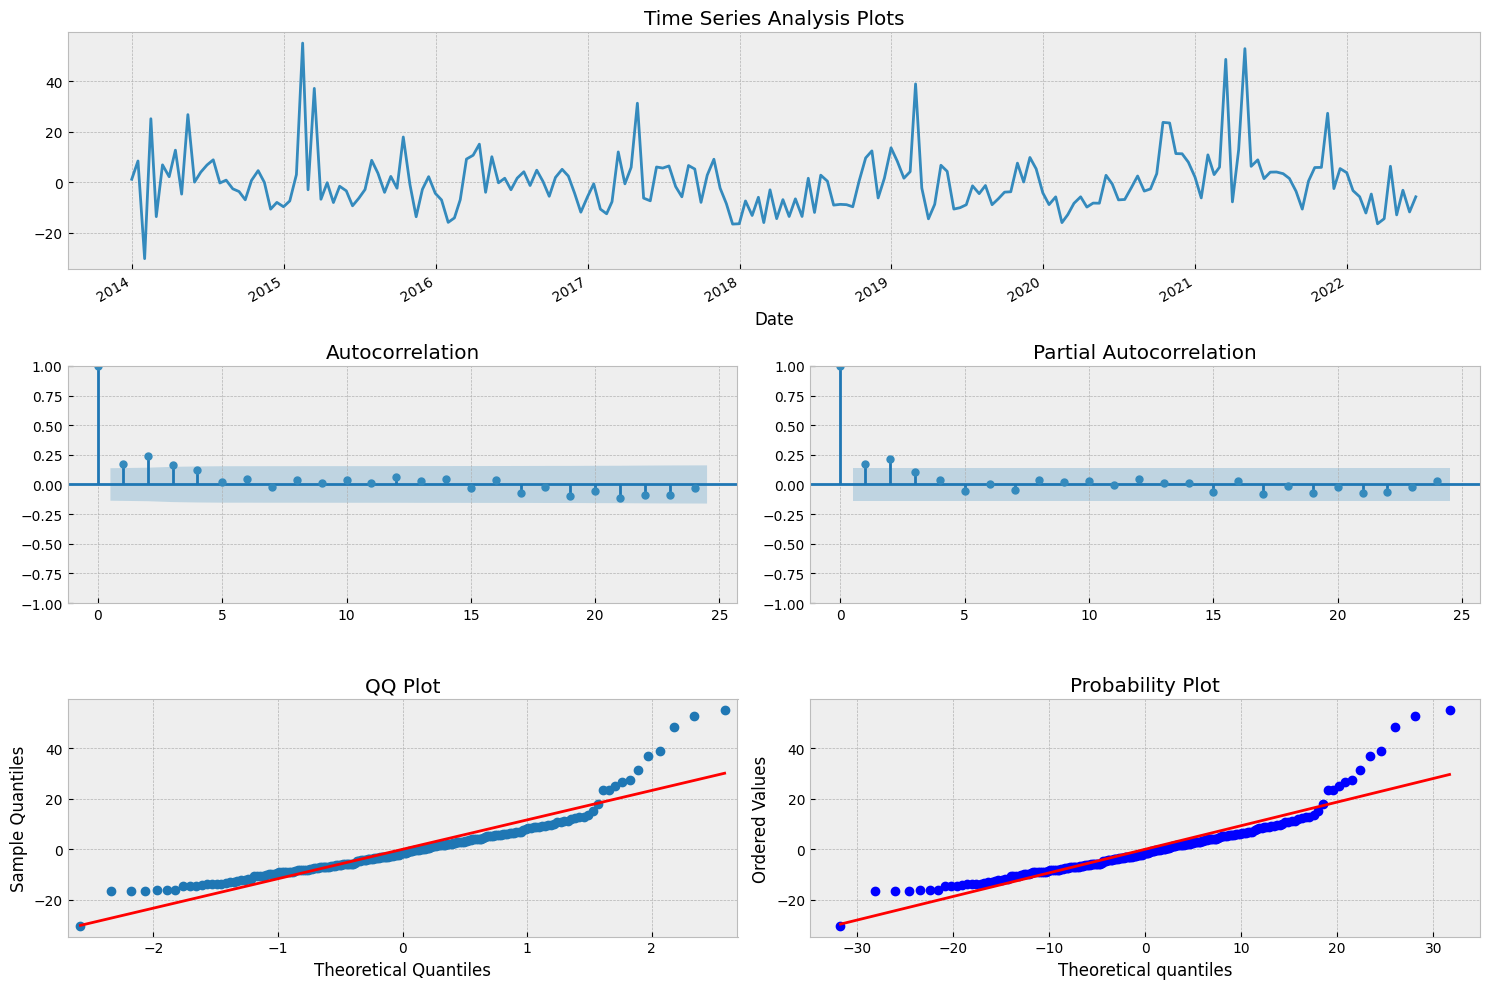

In [74]:
diff_df = differencing(df, order=1, l=30, show=True)
df_trend =  trend(df, True)
tsplot(df_trend)

Arima


In [129]:
prop = df
exog = pd.concat((temp, per), axis=1)
model_1_0 = pm.auto_arima(prop,X=exog, d=1,
                      start_p=0, start_q=0, max_order=6,trace=True,D=1, seasonal=True, m=24)  

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=1507.694, Time=1.45 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1575.771, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1475.215, Time=1.36 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=1540.992, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=1468.166, Time=8.99 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=1460.032, Time=16.95 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=1458.032, Time=2.49 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(1,1,2)[24]             : AIC=inf, Time=28.16 sec
 ARIMA(1,1,0)(0,1,2)[24]             : AIC=1457.929, Time=9.08 sec
 ARIMA(0,1,0)(0,1,2)[24]             : AIC=1507.546, Time=11.73 sec
 ARIMA(2,1,0)(0,1,2)[24]             : AIC=1439.518, Time=11.52 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Time=1.95 sec
 ARIMA(2,1,0)(1,1,2)[24]           

SARIMAX(3, 1, 1)(0, 1, 2) - 1424.448/1453.135
SARIMA(0,1,1)(1,0,2)

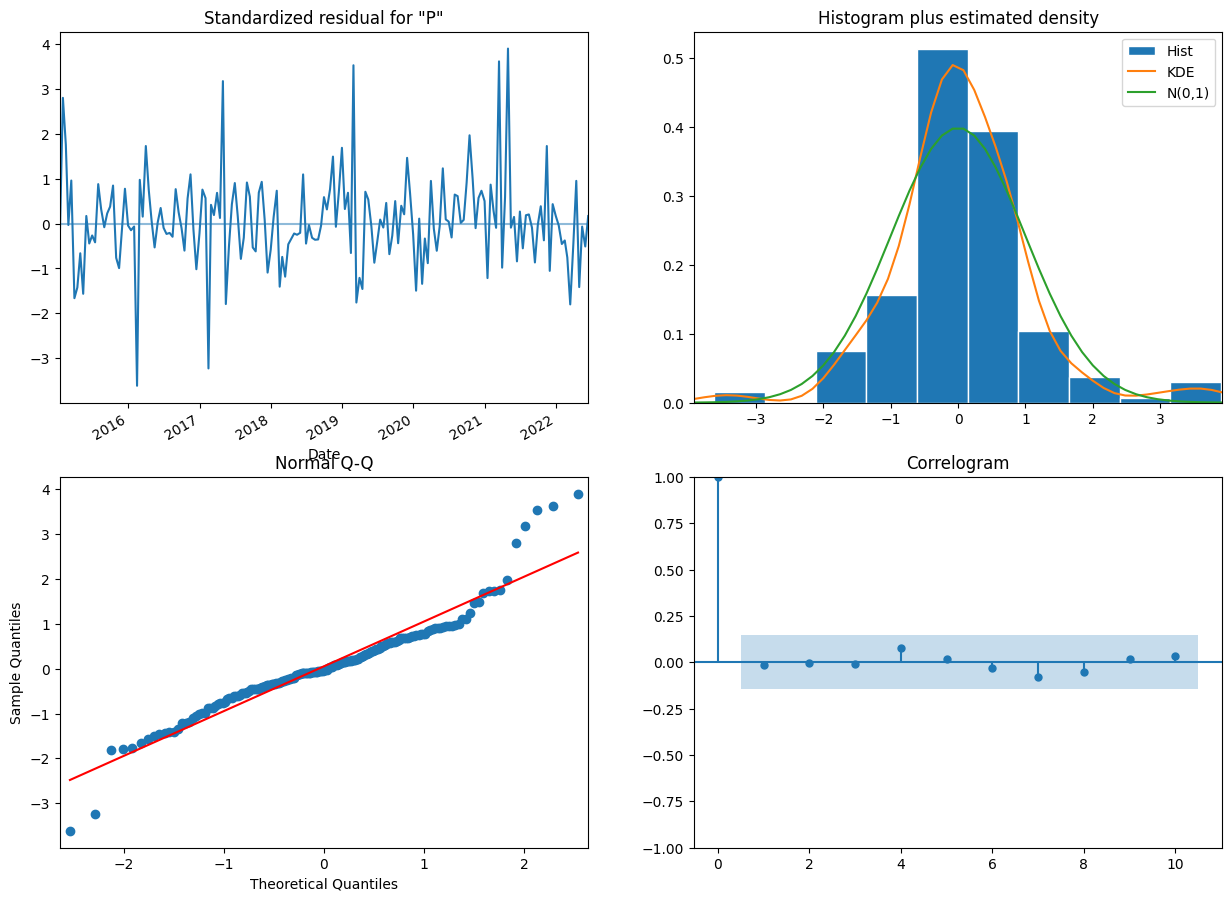

                                        SARIMAX Results                                        
Dep. Variable:                                    PM10   No. Observations:                  204
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2], 24)   Log Likelihood                -703.224
Date:                                 Fri, 23 Dec 2022   AIC                           1424.448
Time:                                         00:05:01   BIC                           1453.135
Sample:                                     12-31-2013   HQIC                          1436.080
                                          - 06-15-2022                                         
Covariance Type:                                   opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temp              1.4059      0.556      2.527      0.012       0.31

In [123]:
model = SARIMAX(prop, exog=exog, order=(3, 1, 1), seasonal_order=(0, 1, 2, 24))
results = model.fit()
results.plot_diagnostics(figsize=(15,12), )
plt.show()
print(results.summary())


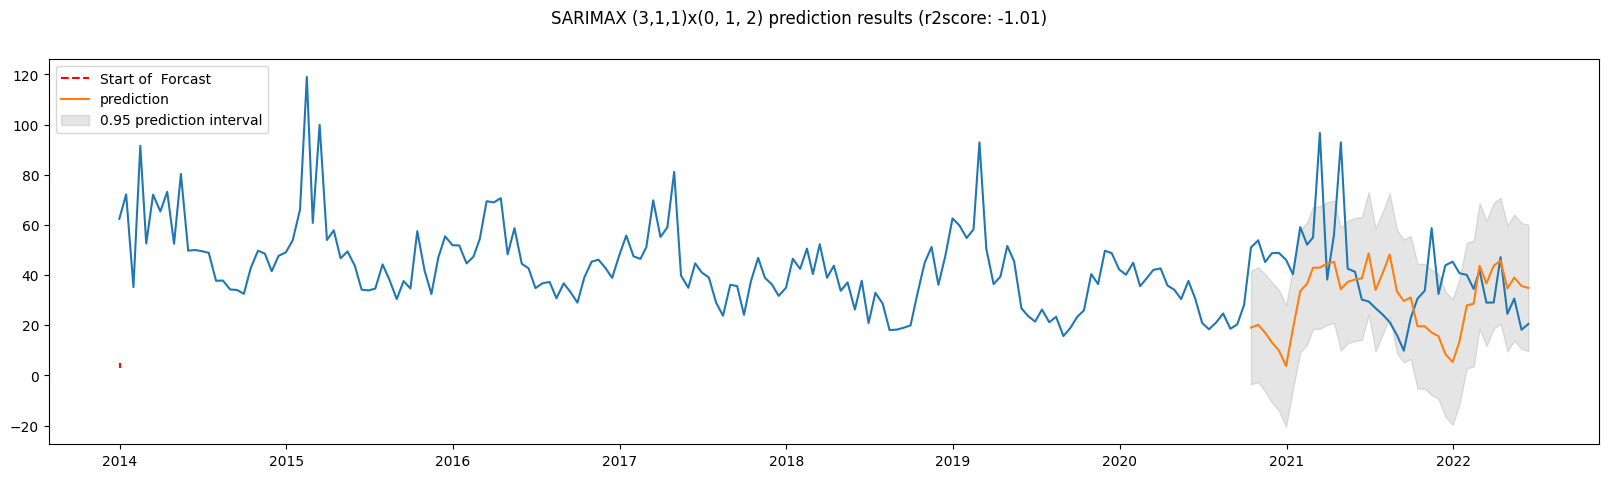

In [125]:
train_set, test_set = train_test_split(prop, test_size = 0.2, shuffle=False)
train_exog, test_exog = train_test_split(exog, test_size = 0.2, shuffle=False)
y_pred = results.get_forecast(len(test_set), exog=test_exog)
pred = y_pred
pred_value = pred.predicted_mean

#upper bound
pred_ub = pred.conf_int().iloc[:,0]

#lower bound
pred_lb = pred.conf_int().iloc[:,1]
pred_index = list(test_set.index)
r2 = r2_score(test_set, pred_value)
fig, ax= plt.subplots(figsize=(20,5))
ax.plot(prop.index, prop)
ax.vlines(pd.to_datetime('2014-01-01'), 3,5, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(pred_index, pred_value, label='prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k',
               alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMAX (3,1,1)x(0, 1, 2) prediction results (r2score: {round(r2,2)})')
plt.show()